In [2]:
import numpy as np
import matplotlib.pyplot as plt

(198, 316)
<class 'numpy.ndarray'>
[[209 210 210 ...  87  79  60]
 [210 210 210 ...  88  79  59]
 [210 210 210 ...  88  79  59]
 ...
 [147 149 150 ... 134 131 130]
 [148 149 149 ... 132 130 129]
 [148 149 149 ... 131 129 128]]


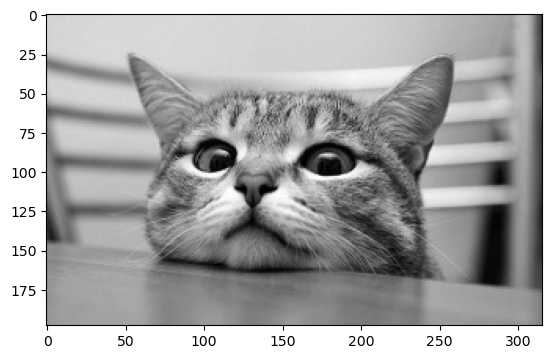

In [50]:
import cv2 as cv

pic_adress = 'cat_3.jpg'

pic = cv.imread (pic_adress)
pic = cv.cvtColor(pic, cv.COLOR_BGR2GRAY)
print (pic.shape)
print (type (pic))
print (pic [:,:])

plt.imshow (pic [:, :], cmap= 'gray')
plt.show ()


Phi:
[[105.91826493 123.02919142 124.36903679 124.69889809]
 [123.02919142 105.91826493 123.73898218 124.04338916]
 [124.36903679 123.73898218 105.91826493 123.73898218]
 [124.69889809 124.04338916 123.73898218 105.91826493]]

R:
[123.73898218 124.10774405 123.02919142 124.36903679]

aCoefs:
[0.26876692 0.2269454  0.30362169 0.23728846]

pic_recons size: (198, 316)


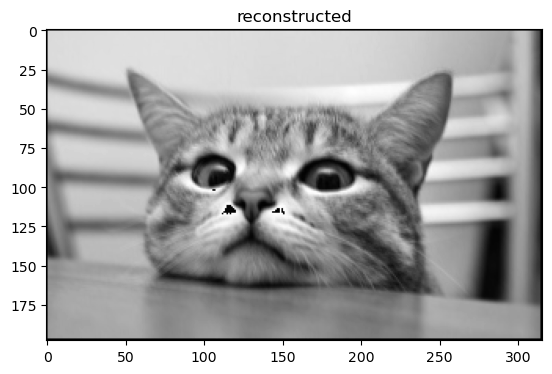

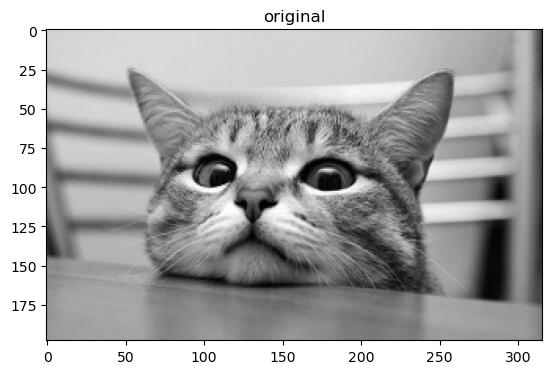

MSE Score:55.656341900012784


In [70]:
from numpy import mean

# Compression:

R22 = R33 = R44 = R55 = mean (mean (pic * pic))
R12 = R34 = R45 = mean ( mean (pic[: , 1:-1] * pic[: , 2:]))
R13 = mean (mean (pic[1:-1, 1:-1] * pic[2:, 2:]))
R14 = R23 = mean (mean (pic[1:-1 , :] * pic[2:, :]))
R15 = R24 = mean (mean (pic[2:, 1:-1] * pic[1:-1, 2:]))
R25 = mean (mean (pic[1:-1, 3:] * pic[2:, 1:-2]))
R35 = mean (mean (pic[:, 3:] * pic[:, 1:-2]))

Phi = np.array ([[R22, R23, R24, R25],
                 [R23, R22, R34, R35],
                 [R24, R34, R22, R45],
                 [R25, R35, R45, R22]])

R = np.array ([R12, R13, R14, R15])

aCoefs = np.matmul(np.linalg.inv(Phi) , R)

print ('\nPhi:\n{}\n'.format (Phi))
print ('R:\n{}\n'.format (R))
print ('aCoefs:\n{}\n'.format (aCoefs))

# Reconstruction:

pic_recons_fromzero = np.zeros (pic.shape, dtype='uint8')
pic_recons_fromzero[:,0] = pic[:,0]
pic_recons_fromzero[0,:] = pic[0,:]

print ('pic_recons size: {}'.format (pic_recons_fromzero.shape))


for i in range (1 , pic.shape[0]-1):
    for j in range (1, pic.shape[1]-1):
        pic_recons_fromzero [i, j] = aCoefs[0]*pic_recons_fromzero[i-1,j] + aCoefs[1]*pic_recons_fromzero[i-1,j+1] + aCoefs[2]*pic_recons_fromzero[i,j+1] + aCoefs[3]*pic_recons_fromzero[i+1,j+1]

plt.imshow (pic_recons_fromzero)

pic_recons_frompic = np.zeros (pic.shape, dtype='uint8')

for i in range (1 , pic.shape[0]-1):
    for j in range (1, pic.shape[1]-1):
        pic_recons_frompic [i, j] = aCoefs[0]*pic[i-1,j] + aCoefs[1]*pic[i-1,j+1] + aCoefs[2]*pic[i,j+1] + aCoefs[3]*pic[i+1,j+1]

plt.imshow (pic_recons_frompic, cmap='gray')
plt.title (label='reconstructed')
plt.show ()
plt.imshow (pic, cmap='gray')
plt.title (label='original')
plt.show()

def mse(img1, img2): # MSE Score
   h, w = img1.shape
   diff = cv.absdiff (img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse

mse_score = mse(pic, pic_recons_frompic)
print ('MSE Score:{}'.format (mse_score))



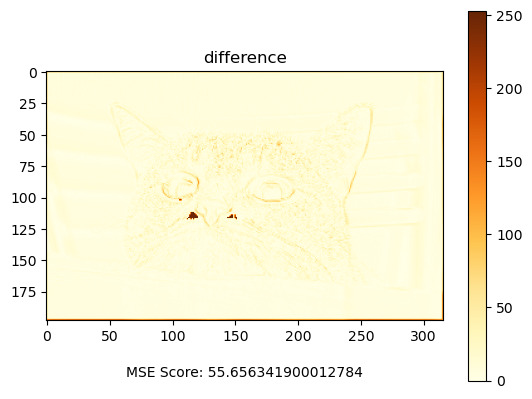

[[209 210 210 ...  87  79  60]
 [210   7   8 ...   4  13  59]
 [210   7   8 ...   4  13  59]
 ...
 [147   5   6 ...   2   3 130]
 [148   5   7 ...   3   4 129]
 [148 149 149 ... 131 129 128]]


In [78]:
plt.imshow (cv.absdiff (pic, pic_recons_frompic), cmap= 'YlOrBr')
plt.title (label='difference')
plt.xlabel ('\nMSE Score: {}'.format (mse_score))
plt.colorbar ()
plt.show()
print (cv.absdiff (pic, pic_recons_frompic))